# Randomized Benchmarking

In this notebook we explore the subset of methods in `randomized_benchmarking.py` that are related specifically to standard randomized benchmarking. 

This includes 

- generating pyquil `Program`s that constitute a sequence of random Clifford gates.

- grouping sequences on disjoint sets of qubits into 'simultaneous' or 'parallel' RB experiments

- running these experiments on a quantum computer and isolating the relevant measurement results

- fitting an exponential decay model to the data in order to estimate the RB decay parameter

- converting the estimated RB decay parameter into an estimate of the average Clifford gate error on the given qubits


For information and examples concerning specifically [interleaved RB](randomized_benchmarking_interleaved.ipynb) or [unitarity RB](randomized_benchmarking_unitarity.ipynb) please refer to the respective dedicated notebooks in `/examples/`




## Motivation and Background

Randomized benchmarking is a commonly used protocol for characterizing an 'average performance' for gates on a quantum computer. It exhibits efficient scaling in the number of qubits over which the characterized gateset acts and is robust to state preparation and measurement noise. The RB decay parameter which is estimated in this procedure can be related to an estimate of 'average gate error' to the ideal, although some care is needed in interpreting this quantity; in particular note that the estimated gate error is *not* the gate infidelity averaged over the *native gateset* for our QPU. When we say gate error below we refer to this more nuanced notion of average *Clifford* gate error. 

The main idea of the protocol is to employ random sequences of gates where the ideal composite operation of the sequence is the identity. To produce such a sequence of depth `m+1`, each of the first `m` gates in the sequence are picked uniformly at random from the Clifford group. Using the group composition and inverse property the last gate is then uniquely determined as the Clifford element which inverts the composition of the previous `m` gates. For illustration refer to this snippet from appendix A1 of [Logical Randomized Benchmarking](https://arxiv.org/pdf/1702.03688.pdf)


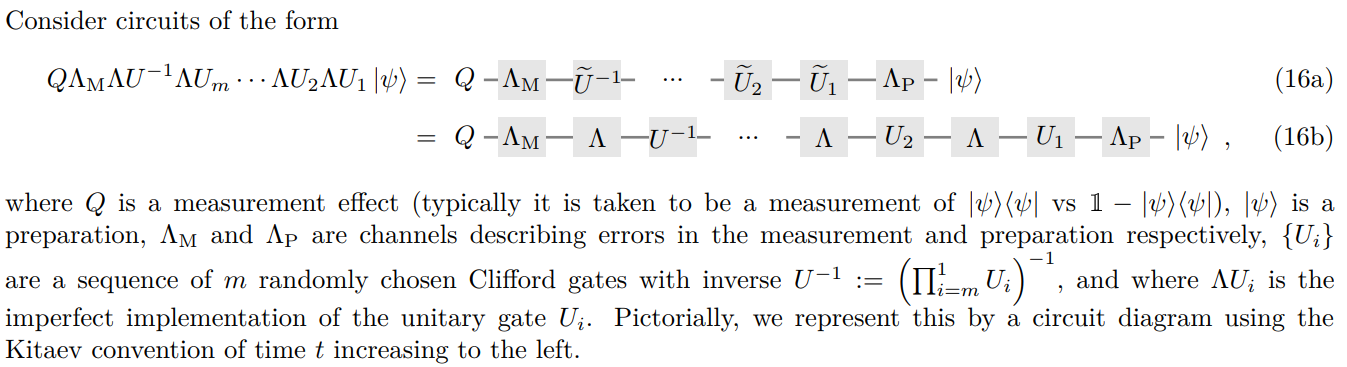


In the presence of noise the actual sequence of Cliffords $[U^{-1}, U_m, U_{m-1}, \dots, U_2, U_1]$ is affected by noise $\Lambda$, and there is state preparation $\Lambda_P$ and measurement error $\Lambda_M$, so the circuit does not enact an identity operation. Instead there is some 'survival probability' `< 1` of measuring the initial state after enacting the sequence. After estimating this 'survival probability' over many independent random sequences of increasing depth $d$ one can fit an exponential decay of the form (under some assumptions):

$$A_0 p^d + B_0$$

We get this relatively simple form thanks to the fact that averaging over Clifford sequences effectively averages any noise channel $\Lambda$ to the depolarizing channel; this, in turn, is because the Clifford group forms a [unitary 3-design](https://en.wikipedia.org/wiki/Quantum_t-design).

Below we've saved a plot of 2q RB data. Each data point is the survival probability estimated for a single sequence of a particular depth. The fit parameters $A_0$ = amplitude, $p$ = decay, $B_0$ = baseline are reported in the `variables` section below the plot:


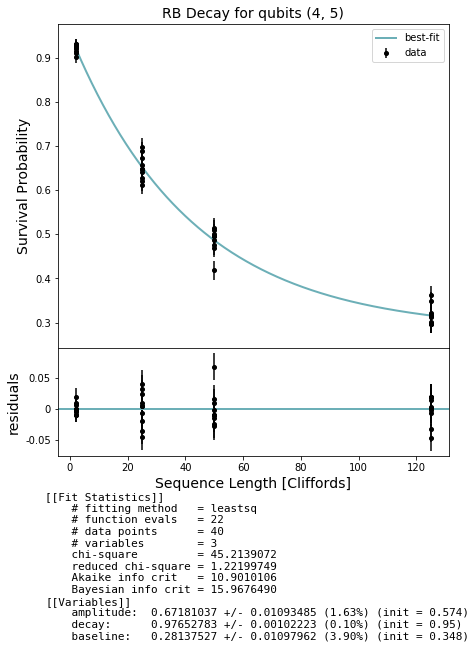



The parameter $p$ estimated from this fit is the RB 'decay' which can be related to the average gate error $r$ by

$$ r = 1 - p - (1 - p) / \textrm{dim} $$

A brief summary of the procedure follows:

- Select some set of depths over which you expect the survival probability to decay significantly

- Generate many random sequences for each depth

- Estimate the 'survival probability' for each sequence by taking the fraction of outcomes matching the initial state over many shots. Here we use the `ObservablesExperiment` framework which estimates observable expectation values from which we can calculate the survival probability.

- Fit an exponential decay model to the estimated survival probabilities. 

- Extract the decay parameter from the fit and convert to 'average gate error'

Note that the interpretation of RB is an active field of research; see [Wallman](https://arxiv.org/abs/1703.09835v4) and [Proctor et al.](https://arxiv.org/abs/1702.01853) for more information.

The references below are a starting point for general details about the RB protocol:

| [RB] *Scalable and Robust Randomized Benchmarking of Quantum Processes*.  
|     Magesan et al.  
|     Phys. Rev. Lett. 106, 180504 (2011).  
|     https://dx.doi.org/10.1103/PhysRevLett.106.180504  
|     https://arxiv.org/abs/1009.3639  

| [RBB] *Randomized Benchmarking of Quantum Gates*.  
|      Knill et al.  
|      Phys. Rev. A 77, 012307 (2008).  
|      https://doi.org/10.1103/PhysRevA.77.012307  
|      https://arxiv.org/abs/0707.0963  

| [SNE] *Scalable Noise Estimation with Random Unitary Operators*.  
|      Emerson et al.  
|      J. Opt. B: Quantum Semiclass. Opt. 7 S347 (2005)  
|      https://doi.org/10.1088/1464-4266/7/10/021  
|      https://arxiv.org/abs/quant-ph/0503243  

## A simple single qubit example

We'll start with importing the necessary methods from the `randomized_benchmarking.py` module and setting up a demo quantum computer object to characterize along with a benchmarker object that will generate our Clifford sequences.

Since our demo is using a quantum virtual machine (QVM) you will need a qvm server. Additionally, we currently rely on a benchmarker object to generate the Clifford sequences, which requires a quilc server.

In [1]:
# Needs in terminal:
# $ quilc -S
# $ qvm -S

import numpy as np

from pyquil.api import get_benchmarker
from forest.benchmarking.randomized_benchmarking import (generate_rb_sequence,
                                                         generate_rb_experiments, acquire_rb_data,
                                                        get_stats_by_qubit_group, fit_rb_results)

%matplotlib inline

In [2]:
from pyquil.api import get_qc, get_benchmarker
qc = get_qc("9q-square-noisy-qvm")
bm = get_benchmarker()

### Create a single sequence
First we can generate a single sequence of 5 Clifford gates on qubit 0 to inspect. (Note we won't have to actually call this individually to create a typical experiment)

In [3]:
# the results are stochastic and can be seeded with random_seed = #
sequence = generate_rb_sequence(bm, qubits=[0], depth=5)
for gate in sequence:
    print(gate) # each 'gate' is a separate pyquil Program

RZ(-pi) 0
RZ(-pi) 0

RX(-pi/2) 0
RZ(-pi/2) 0
RX(-pi/2) 0

RX(pi/2) 0
RZ(pi/2) 0
RX(-pi/2) 0

RX(-pi/2) 0
RZ(pi/2) 0

RZ(-pi/2) 0
RX(-pi/2) 0



### Generate a single qubit RB experiment

Now let's start in on a full experiment on a single qubit. For the RB protocol we need to generate many sequences for many different depths, and we need to measure each sequence many times. We use the `ObservablesExperiment` framework, consistent with the rest of forest.benchmarking, to estimate the expectation of the `Z` observable, $E[Z]$, after running each sequence on our qubit; the survival probability will simply be $(E[Z] + 1)/2$.

Since we will use the same experiment generation for 'simultaneous' rb experiments we will need to specify our qubit as belonging to an isolated single-qubit group.

In [4]:
qubit_groups = [(2,)] # characterize the 1q gates on qubit 2
num_sequences_per_depth = 10
depths = [d for d in [2,25,50,125] for _ in range(num_sequences_per_depth)]  # specify the depth of each sequence

experiments_1q = generate_rb_experiments(bm, qubit_groups, depths)
print(experiments_1q[0])  
# shows the overall sequence being generated 
# and that we'll be initializing qubit 2 to the zero state and measuring the Z observable. 

RZ(-pi/2) 2; RX(-pi) 2; RZ(-pi/2) 2; RX(-pi) 2
0: Z+_2→(1+0j)*Z2


### Acquire data

We can immediately acquire data for these experiments.

In [5]:
num_shots = 500
# run the sequences on the qc object initialized above
results_1q = acquire_rb_data(qc, experiments_1q, num_shots, show_progress_bar=True)
print(results_1q[0])
# shows the estimates for each observable on sequence 0
# for now there's only one observable so we get a list of length 1

100%|██████████| 40/40 [00:23<00:00,  1.71it/s]

[ExperimentResult[Z+_2→(1+0j)*Z2: 0.964 +- 0.011891509576163995]]


### Analyze and plot
We can unpack the results from each `ExperimentResult` and pass this into a fit. 

In [6]:
# in this case it is simple to unpack the results--there is one result per sequence
expectations = [[res[0].expectation] for res in results_1q]
std_errs = [[res[0].std_err] for res in results_1q]

# we can also use a convenience method, which will be especially helpful with more complicated experiments
stats_q2 = get_stats_by_qubit_group(qubit_groups, results_1q)[(2,)]

# demonstrate equivalence
np.testing.assert_array_equal(expectations, stats_q2['expectation'])
np.testing.assert_array_equal(std_errs, stats_q2['std_err'])

# fit the exponential decay model
fit_1q = fit_rb_results(depths, expectations, std_errs, num_shots)

This fit contains estimates for the rb decay from which we can get the gate error.

We can also plot a figure 

0.9999979683958936


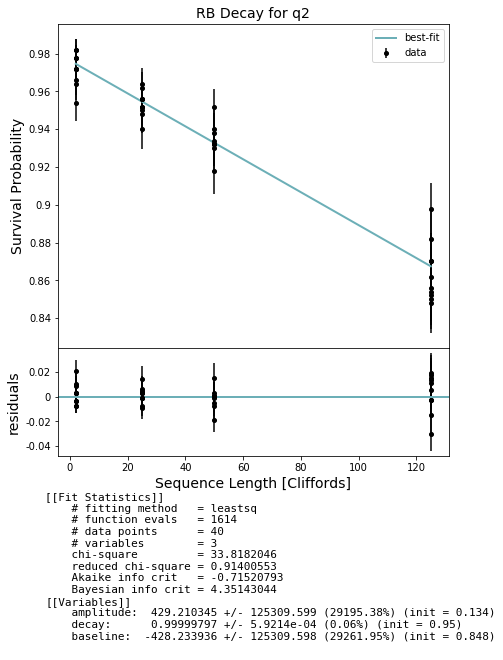

In [7]:
from forest.benchmarking.plotting import plot_figure_for_fit

fig, ax = plot_figure_for_fit(fit_1q, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability", title='RB Decay for q2')
rb_decay_q2 = fit_1q.params['decay'].value
print(rb_decay_q2)

## Simultaneous RB

Running simultaneous experiments and multi-qubit experiments follows the same work flow. Here we'll demonstrate a 1q, 2q simultaneous experiment. 'Simultaneous' has to be qualified somewhat on a real QPU -- the physical action of gates is not guaranteed to occur in the order specified by a quil program (a quil program really only specifies causal relationships). Further one sequence of gates may terminate before another 'simultaneous' sequence has. Measurement only occurs when all gates have executed. 

### Generate the simultaneous experiment

In [8]:
qubit_groups = [(2,), (4,5)] # characterize the 1q gates on qubit 2, and the 2q Cliffords on (4,5)
num_sequences_per_depth = 10
# specify the depth of each simultaneous sequence
depths = [d for d in [2,25,50,125] for _ in range(num_sequences_per_depth)]  

experiments_simult = generate_rb_experiments(bm, qubit_groups, depths)
print(experiments_simult[0])  
# note that this sequence consists of only 1q gates on qubit 2 
# while qubits 4 and 5 should have some CZ gates

RX(-pi/2) 2; RZ(-pi) 2; CZ 4 5; RX(-pi/2) 5; RX(pi/2) 4; ... 8 instrs not shown ...; CZ 4 5; RZ(pi/2) 5; RX(pi/2) 5; CZ 4 5; RZ(-pi/2) 4
0: Z+_2→(1+0j)*Z2, Z+_4 * Z+_5→(1+0j)*Z5, Z+_4 * Z+_5→(1+0j)*Z4, Z+_4 * Z+_5→(1+0j)*Z4Z5


### Acquire data
Collecting this data on a QVM can take a few minutes

In [9]:
num_shots = 500
# run the sequences on the qc object initialized above
results_simult = acquire_rb_data(qc, experiments_simult, num_shots, show_progress_bar=True)
print(results_simult[0])
# shows the estimates for each observable on sequence 0
# there is one observable on q2 and three on qubits (4,5)

100%|██████████| 40/40 [01:24<00:00,  2.11s/it]

[ExperimentResult[Z+_2→(1+0j)*Z2: 0.948 +- 0.014233481654184263], ExperimentResult[Z+_4 * Z+_5→(1+0j)*Z5: 0.896 +- 0.019858700863853104], ExperimentResult[Z+_4 * Z+_5→(1+0j)*Z4: 0.9 +- 0.019493588689617924], ExperimentResult[Z+_4 * Z+_5→(1+0j)*Z4Z5: 0.828 +- 0.025076522884961535]]


### Analyze and plot

We plot each result. While the one qubit decay has a baseline (ideal horizontal asymptote) of .5, the two qubit decay has a baseline of .25.

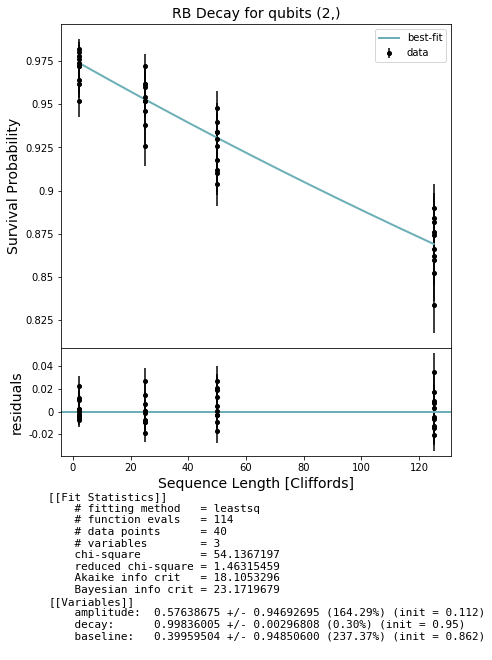

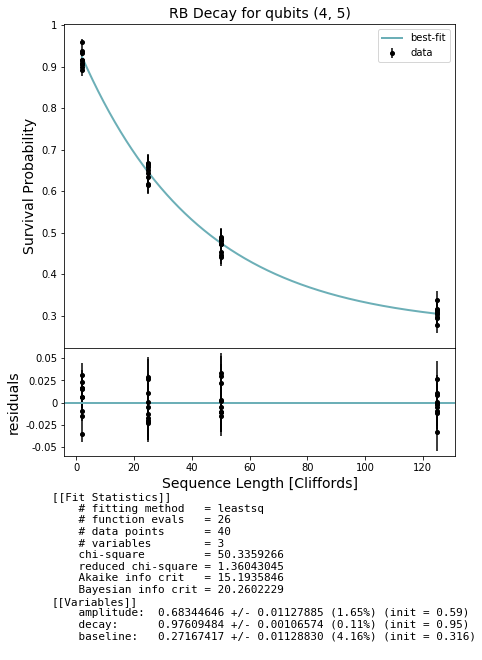

In [10]:
stats_simult = get_stats_by_qubit_group(qubit_groups, results_simult)

fits = []
for qubits, stats in stats_simult.items():
    exps = stats['expectation']
    std_errs = stats['std_err']
    # fit the exponential decay model
    fit = fit_rb_results(depths, exps, std_errs, num_shots)
    fits.append(fit)
    fig, ax = plot_figure_for_fit(fit, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability", title=f'RB Decay for qubits {qubits}')


In general we expect that running a simultaneous RB experiment on a real QPU will result in smaller decay values due to effects such as cross-talk; this won't show up on a QVM unless you create a noise model that captures such effects.

## Advanced usage

### Modifying the Clifford sequences

We have broken down experiment generation into two steps if you wish to use the basic functionality provided in the RB module but want to modify the individual Clifford elements in each sequence, e.g. by replacing with a logical operation on logical qubits. 

In [11]:
from forest.benchmarking.randomized_benchmarking import generate_rb_experiment_sequences
# similar to generate_rb_experiments we need a benchmarker and the depths for each sequence. 
# unlike generate_rb_experiments we only specify a group of qubits rather than a list of simultaneous qubit groups
qubits = (2,3)
num_sequences_per_depth = 10
depths = [d for d in [2,25,50,125] for _ in range(num_sequences_per_depth)]  # specify the depth of each sequence

sequences_23 = generate_rb_experiment_sequences(bm, qubits, depths)
print(sequences_23[0])
# here we see that each sequence is given with the division into Clifford gates rather than as a single program
# if we wished, we could modify these sequences at a Clifford-gate level.

[<pyquil.quil.Program object at 0x7fbd15e79f28>, <pyquil.quil.Program object at 0x7fbd15e79d68>]


In [12]:
from forest.benchmarking.randomized_benchmarking import group_sequences_into_parallel_experiments
# now we can collect our modified sequences into an experiment
expt_2q_non_simult = group_sequences_into_parallel_experiments([sequences_23], [qubits])
print(f'A 2q experiment on qubits {qubits}')
print(expt_2q_non_simult[0])

# this generalizes to simultaneous experiments
sequences_01 = generate_rb_experiment_sequences(bm, (0,1), depths)
expt_2q_simult = group_sequences_into_parallel_experiments([sequences_23, sequences_01], [qubits, (0,1)])
print('\nA simultaneous 2q experiment.')
print(expt_2q_simult[0])

A 2q experiment on qubits (2, 3)
RX(-pi/2) 3; RZ(-pi/2) 2; RX(pi/2) 2; CZ 2 3; RX(-pi/2) 2; ... 2 instrs not shown ...; RX(-pi/2) 2; CZ 2 3; RX(pi/2) 3; RX(pi/2) 2; RZ(-pi/2) 2
0: Z+_2 * Z+_3→(1+0j)*Z3, Z+_2 * Z+_3→(1+0j)*Z2, Z+_2 * Z+_3→(1+0j)*Z2Z3

A simultaneous 2q experiment.
RX(-pi/2) 3; RZ(-pi/2) 2; RX(pi/2) 2; CZ 2 3; RX(-pi/2) 2; ... 14 instrs not shown ...; RX(-pi/2) 0; CZ 0 1; RX(-pi/2) 1; CZ 0 1; RZ(-pi/2) 0
0: Z+_2 * Z+_3→(1+0j)*Z3, Z+_2 * Z+_3→(1+0j)*Z2, Z+_2 * Z+_3→(1+0j)*Z2Z3, Z+_0 * Z+_1→(1+0j)*Z1, Z+_0 * Z+_1→(1+0j)*Z0, Z+_0 * Z+_1→(1+0j)*Z0Z1


### Very fast RB by few point measurements

If we have prior information (say by running RB earlier) that p=0.9 we may want to monitor the decay as a function of time to see if our experiment is drifting in time.

A fisher information analysis shows that the optimal sequence length to sample given $p$ scales as
$$
d^{\rm opt} \sim - \frac{1}{\ln p}.
$$

Suppose the gate drifts with time and one has previously characterized the drift by doing repeated RB. Then one could imagine sampling at sequence lengths that correspond to the mean of the distribution of $\langle p \rangle$ and $\langle p \rangle \pm {\rm stdev}(p)$. For example if $\langle p \rangle = 0.9$ and ${\rm stdev}(p) = 0.05$ then we might want to sample at $d = [6, 10, 19]$.

In [13]:
qubit_groups = [(2,)] # characterize the 1q gates on qubit 2
num_sequences_per_depth = 10
depths = [d for d in [6, 10, 19] for _ in range(num_sequences_per_depth)]  # specify the depth of each sequence
print(depths)
experiments_1q = generate_rb_experiments(bm, qubit_groups, depths)  

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


[ExperimentResult[Z+_2→(1+0j)*Z2: 0.92 +- 0.017527121840165315]]


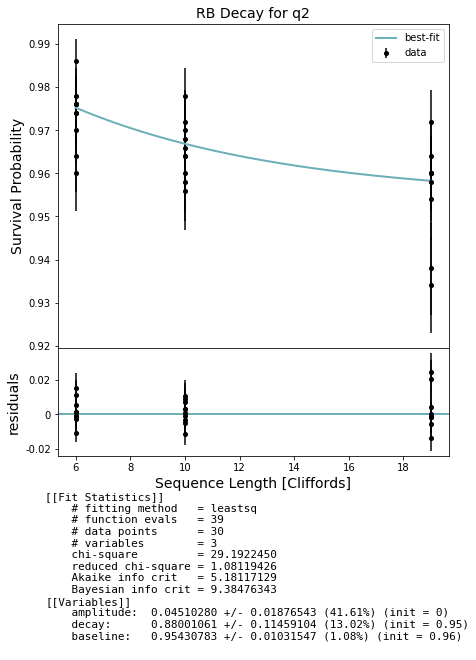

In [14]:
num_shots = 500
# run the sequences on the qc object initialized above
results_1q = acquire_rb_data(qc, experiments_1q, num_shots, show_progress_bar=True)
print(results_1q[0])
# in this case it is simple to unpack the results--there is one result per sequence
expectations = [[res[0].expectation] for res in results_1q]
std_errs = [[res[0].std_err] for res in results_1q]
# fit the exponential decay model
fit_1q = fit_rb_results(depths, expectations, std_errs, num_shots)
fig, ax = plot_figure_for_fit(fit_1q, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability", title='RB Decay for q2')